In [1]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [3]:
summary_dic = {}
vaf_list = pd.read_csv('max_vaf.csv').values.tolist()

def find_match(sample_id):
    global vaf_list
    for sample in vaf_list:
        if (sample[0] in sample_id) or (sample_id in sample[0]):
            return sample[1]
    return -1

def vaf_correlation(cohort_name, pred_list):
    pred_tfs, max_vafs = [], []
    for sample in pred_list:
        if sample[0] == cohort_name:
            max_vaf = find_match(sample[1])
            if max_vaf != -1:
                pred_tfs.append(sample[-1])
                max_vafs.append(max_vaf)
    pearson_corr = round( pearsonr(pred_tfs, max_vafs)[0], 2 )
    return pearson_corr

def get_youden(pred_list):
    TP, TN, FP, FN = 0, 0, 0, 0
    thr = 0.03
    for sample in pred_list:
        cohort, predicted = sample[0], sample[-1]
        true = 0 if ('healthy' in cohort) else 1
        if predicted>thr and true>0.0:
            TP += 1
        elif predicted<=thr and true>0.0:
            FN+=1
        elif predicted>thr and true==0.0:
            FP+=1
        elif predicted<=thr and true==0.0:
            TN+=1
    SN = round(TP/(TP+FN), 3)
    SP = round(TN/(TN+FP), 3)
    Y = round(SN + SP -1, 2)
    return Y

def get_auROC(pred_list):
    cancer_cnt, healthy_cnt = 0, 0
    cancer_tfs, healthy_tfs, pred_tfs = [], [], []
    for pred in pred_list:
        cohort, predicted = pred[0], pred[-1]
        if 'healthy' in cohort:
            healthy_cnt += 1
            healthy_tfs.append(predicted)
        else:
            cancer_cnt += 1
            cancer_tfs.append(predicted)
    pred_tfs.extend(cancer_tfs)
    pred_tfs.extend(healthy_tfs)
    trues = [1]*cancer_cnt + [0]*healthy_cnt
    fpr, tpr, _ = metrics.roc_curve(trues, pred_tfs)
    auc = round(metrics.roc_auc_score(trues, pred_tfs), 2)
    return auc
                

def load_wgs_dic(is_correction, coverage):
    global summary_dic, vaf_list
    correct_str = 'correction' if is_correction==True else 'no_correction'
    csv_file = f'final_files/ichorCNA_{correct_str}_preds_{coverage}.csv'
    pred_list = pd.read_csv(csv_file).values.tolist()
    summary_dic[f'crc_batch2__vaf__{correct_str}__{coverage}'] = vaf_correlation('crc_batch2', pred_list)
    summary_dic[f'BRCA_gis__vaf__{correct_str}__{coverage}'] = vaf_correlation('BRCA_gis', pred_list)
    summary_dic[f'youden__{correct_str}__{coverage}'] = get_youden(pred_list)
    summary_dic[f'auROC__{correct_str}__{coverage}'] = get_auROC(pred_list)

    
configs = [[True, '0.1X'], [False, '0.1X']]
for config in configs:
    load_wgs_dic(config[0], config[1])

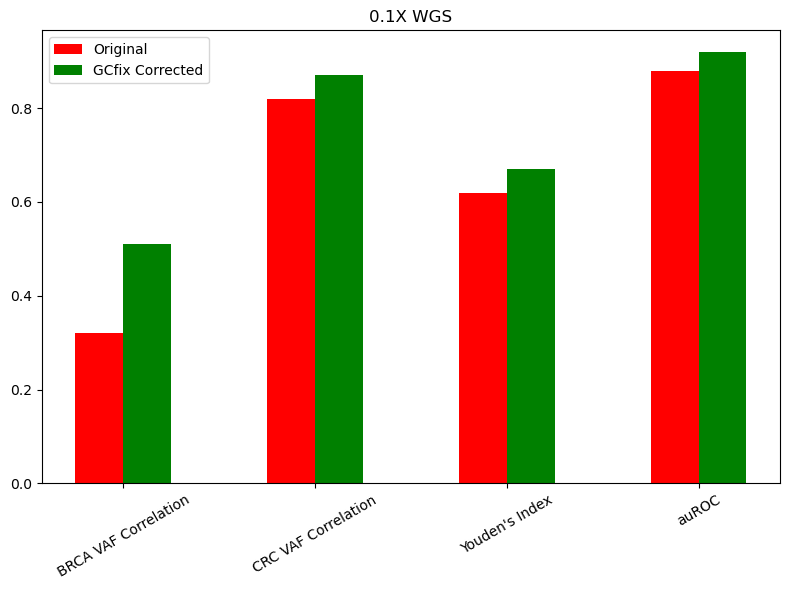

In [5]:
def load_data(coverage, correct_str):
    global summary_dic
    corrs = [summary_dic[f'BRCA_gis__vaf__{correct_str}__{coverage}'], summary_dic[f'crc_batch2__vaf__{correct_str}__{coverage}'],
            summary_dic[f'youden__{correct_str}__{coverage}'], summary_dic[f'auROC__{correct_str}__{coverage}']]
    return corrs
    

def compare_performance(coverage):
    conditions = ['BRCA VAF Correlation', 'CRC VAF Correlation', 'Youden\'s Index', 'auROC']
    corr_original = load_data(coverage, 'no_correction')
    corr_corrected = load_data(coverage, 'correction')

    # Bar width and positions
    bar_width = 0.25
    index = np.arange(len(conditions))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot bars
    bars_original = ax.bar(index, corr_original, bar_width, label='Original', color='red', capsize=5)
    bars_corrected = ax.bar(index + bar_width, corr_corrected, bar_width, label='GCfix Corrected', color='green', capsize=5)

    title = f'{coverage} WGS'
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(conditions)
    ax.tick_params(axis='x', labelrotation=30)
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.savefig('Plots/ichor_performance.png', dpi=300)
    
compare_performance('0.1X')